### 8 비지도 학습
#### 8.1 K-평균 알고리즘

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

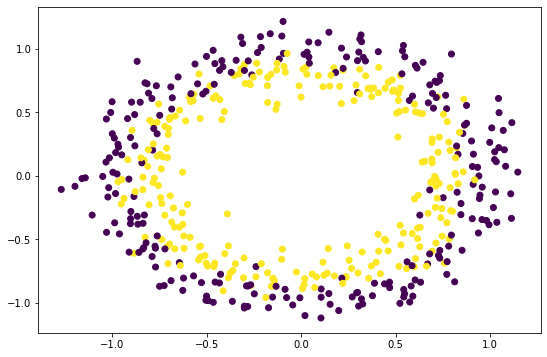

In [4]:
# Make a large circle containing a smaller circle in 2d. 
# A simple toy dataset to visualize clustering and classification algorithms.
# X: ndarray of shape (n_samples, 2)
# The generated samples.
# y: ndarray of shape (n_samples,)
# The integer labels (0 or 1) for class membership of each sample.
X, y = make_circles(n_samples=500, noise=0.1)
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


In [5]:
# numpy sum(), axis(축) 이해
arr = np.random.rand(3,2)
print(arr)
sum_axis0 = np.sum(arr, axis=0) # 배열의 첫번째 차원을 더해서 1개로 만듬 => (*3, 2) => (2,)
sum_axis1 = np.sum(arr, axis=1) # 배열의 두번째 차원을 더해서 1개로 만듬 => ( 3,*2) => (3,)
print(sum_axis0)
print(sum_axis1)

[[0.21186663 0.2711361 ]
 [0.15586643 0.49670415]
 [0.81753934 0.43724902]]
[1.18527239 1.20508926]
[0.48300273 0.65257057 1.25478836]


In [6]:
# 텐서 데이터 변환화기
X = torch.FloatTensor(X)

# K-평균 알고리즘
def L2distance(a,b):
    # 피타고라스 정리 c^2 = a^2+b^2
    # 두점 a, b를 a-b 하면 두 점 사이의 x축 길이와 y축 길이가 구해진다. x축 길이와 y축 길이를 제곱하여 더해 주면 피타고라스 정의
    return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0)

In [16]:
a = torch.tensor([[1,2]])
print(a.size())
a.expand(2,-1)

torch.Size([1, 2])


tensor([[1, 2],
        [1, 2]])

In [18]:
a = np.array([[15, 8, 12], [11, 7, 3]])
np.where(a > 10) # (array([0, 0, 1]), array([0, 2, 0]))

(array([0, 0, 1], dtype=int64), array([0, 2, 0], dtype=int64))

In [23]:
# K-평균 알고리즘
# 1. 임의의 클러스터 중심 좌표 생성
# 2. 모든 점과 각 클러스터 중심 점과의 거리를 계산하여 각점과 가까운 클러스터의 인덱스로 각점을 분류
# 3. 각 클러스터 별로 분류된 각점의 위치를 평균내어 각 클러스터의 중심점으로 업데이트 하고 다시 2번 수행

def kmeans(coordis, num_clusters=2, max_iteration=5):
    # coordis: 좌표 데이터
    # num_clusters: 클러스터 수
    # max_iteration: 평균연산 횟수
    device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
    coordis = coordis.to(device) 
    centroids = torch.rand(num_clusters, coordis.size(1)).to(device) # 클러스터 수만큼의 중심점을 임의로 생성
    for update in range(max_iteration):
        cluster_assign=[] # 각 좌표가 어느 클러스터로 분류되는지의 기준을 클러스터의 인덱스로 하고 해당 인덱스를 좌표의 순서와 일치하도록 저장
        for i in range(coordis.size(0)): # 좌표의 수만큼 반복
            crds = coordis[i].expand(num_clusters, -1) # 하나의 좌표로 각 클러스터의 중심점과의 거리를 알아내기 위해 하나의 좌표를 중심점 숫자와 일치하도록 복제(expand)
            cluster_idx = L2distance(centroids, crds) # 좌표 점과 가장 가까운 클러스터의 인덱스
            cluster_assign.append(cluster_idx.item()) # 클러스터 인덱스를 저장
        
        cluster_assign = np.array(cluster_assign)
        if update != max_iteration-1:
            for i in range(num_clusters): # 클러스터 숫자만큼 반복
                assign_filter = np.where( cluster_assign == i) # 클러스터 인덱스와 일치하는 좌표 즉 해당 클러스터로 분류되는 좌표를 얻기위한 필터
                centroids[i] = torch.mean(coordis[assign_filter], dim=0) # 클러스터에 포함되는 좌표들의 평균을 구해 클러스터 중심점 좌표에 업데이트 한다.
    return cluster_assign, centroids


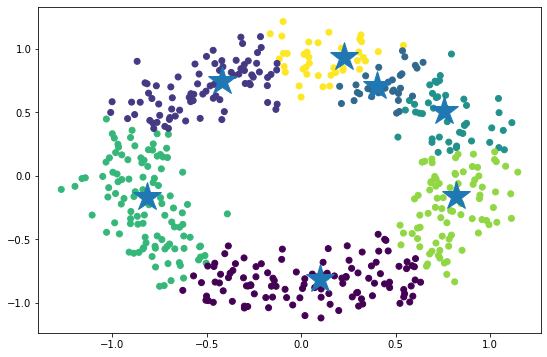

In [32]:
y_pred, centroids = kmeans(X, 7)
centroids = centroids.cpu().numpy()
plt.figure(figsize=(9,6))
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.plot(centroids[:,0], centroids[:,1], "*", markersize=30)
plt.show()

#### 8.3 오토인코더
##### 8.3.1 스택 오토인코더
<p>
1. 오토인코더 란: 
오토인코더(Autoencoder)는 아래의 그림과 같이 단순히 입력을 출력으로 복사하는 신경망이다. 어떻게 보면 간단한 신경망처럼 보이지만 네트워크에 여러가지 방법으로 제약을 줌으로써 어려운 신경망으로 만든다. 예를들어 아래 그림처럼 hidden layer의 뉴런 수를 input layer(입력층) 보다 작게해서 데이터를 압축(차원을 축소)한다거나, 입력 데이터에 노이즈(noise)를 추가한 후 원본 입력을 복원할 수 있도록 네트워크를 학습시키는 등 다양한 오토인코더가 있다. 이러한 제약들은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 방지하며, 데이터를 효율적으로 표현(representation)하는 방법을 학습하도록 제어한다.
</p>
<div>
<img src="./images/오토인코더.png">
</div>
<p>
2. Uncomplete 오토인코더오토인코더는 위의 그림에서 볼 수 있듯이 항상 인코더(encoder)와 디코더(decoder), 두 부분으로 구성되어 있다.</p>
<p>인코더(encoder) : 인지 네트워크(recognition network)라고도 하며, 입력을 내부 표현으로 변환한다.</p>
<p>디코더(decoder) : 생성 네트워크(generative nework)라고도 하며, 내부 표현을 출력으로 변환한다.</p>
<p>오토인코더는 위의 그림에서 처럼, 입력과 출력층의 뉴런 수가 동일하다는 것만 제외하면 일반적인 MLP(Multi-Layer Perceptron)과 동일한 구조이다. 오토인코더는 입력을 재구성하기 때문에 출력을 재구성(reconstruction)이라고도 하며, 손실함수는 입력과 재구성(출력)의 차이를 가지고 계산한다. 위 그림의 오토인토더는 히든 레이어의 뉴런(노드, 유닛)이 입력층보다 작으므로 입력이 저차원으로 표현되는데, 이러한 오토인코더를 Undercomplete Autoencoder라고 한다. undercomplete 오토인코더는 저차원을 가지는 히든 레이어에 의해 입력을 그대로 출력으로 복사할 수 없기 때문에, 출력이 입력과 같은 것을 출력하기 위해 학습해야 한다. 이러한 학습을 통해 undercomplete 오토인코더는 입력 데이터에서 가장 중요한 특성(feature)을 학습하도록 만든다.
</p>
출처: <a href="https://excelsior-cjh.tistory.com/187">https://excelsior-cjh.tistory.com/187</a>

In [2]:
# 라이브러리
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# GPU 연산 정의 및 MNIST 데이터 불러오기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

In [3]:
# 모델 구축
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid())
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [8]:
# 모델, 손실함수, 최적화 정의
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [3]:
# 학습하기
def model_training(model, optimizer, criterion, epoch_roop):
    loss_stack = []
    batch_count = len(trainloader)
    for epoch in range(epoch_roop):
        loss_sum = 0.0    
        for data in trainloader:
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.view(-1, 784)
            inputs = inputs.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, inputs)        
            loss_sum += loss
            loss.backward()
            optimizer.step()
        loss_avg = loss_sum/batch_count
        loss_stack.append(loss_avg.item())
        print(f"epoch: {epoch+1}, loss: {loss_avg}")

    plt.figure(figsize=(9,6))    
    plt.plot(loss_stack)

In [4]:
# 모델 훈련 수행
model_training(model, optimizer, criterion, 10)

NameError: name 'model' is not defined

In [12]:
# 파이토치 모델 저장
PATH = "./models/AutoEncoder.pth" # .pth 파일은 모델이 저장될 파일 (Inference:추론)을 원할 경우 *.pth파일 형식으로 저장
torch.save(model.state_dict(), PATH)

##### 8.3.2 디노이징 오토인코드

학습시 input 값에 가우시한 노이즈 더하면 됨. p176 참고

##### 8.3.3 합성곱 오토인코더

* ConvTranspose2d()함수의 이해 <a href = "https://simonjisu.github.io/deeplearning/2019/10/27/convtranspose2d.html">https://simonjisu.github.io/deeplearning/2019/10/27/convtranspose2d.html</a>

In [36]:
16**.5

4.0

In [4]:
# 피쳐맵 백터화 클래스
class Flatten(nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

# 백터를 사각 피쳐맵으로 변환시키는 클래스
class Deflatten(nn.Module):
    def __init__(self, chcnt):
        super(Deflatten, self).__init__()
        self.chcnt = chcnt
    def forward(self, x):
        #print(x.size())
        vec_len = x.shape[1]
        feature_size = int((vec_len // self.chcnt)**0.5)
        batch_size = x.shape[0]
        return x.view(batch_size, self.chcnt, feature_size, feature_size)

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        k=16
        self.encoder = nn.Sequential(
            nn.Conv2d(1, k, 3, stride=2), nn.ReLU(),
            nn.Conv2d(k, 2*k, 3, stride=2), nn.ReLU(),
            nn.Conv2d(2*k, 4*k, 3, stride=1), nn.ReLU(),
            Flatten(), nn.Linear(1024, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 1024), nn.ReLU(),
            Deflatten(4*k),
            nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), nn.ReLU(),
            nn.ConvTranspose2d(2*k, k, 3, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# 모델, 손실함수, 최적화 정의
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# 학습하기
def convAutoEncoderModel_training(model, optimizer, criterion, epoch_loop):
    loss_stack = []
    batch_count = len(trainloader)
    for epoch in range(epoch_loop):
        loss_sum = 0.0    
        for data in trainloader:
            optimizer.zero_grad()
            inputs, labels = data            
            inputs = inputs.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, inputs)        
            loss_sum += loss
            loss.backward()
            optimizer.step()
        loss_avg = loss_sum/batch_count
        loss_stack.append(loss_avg.item())
        print(f"epoch: {epoch+1}, loss: {loss_avg}")

    plt.figure(figsize=(9,6))    
    plt.plot(loss_stack)

epoch: 1, loss: 0.012727824971079826
epoch: 2, loss: 0.012609186582267284
epoch: 3, loss: 0.012504111044108868
epoch: 4, loss: 0.012400924228131771
epoch: 5, loss: 0.012306451797485352
epoch: 6, loss: 0.012226749211549759
epoch: 7, loss: 0.012148432433605194
epoch: 8, loss: 0.012073188088834286
epoch: 9, loss: 0.012009227648377419
epoch: 10, loss: 0.01194905024021864


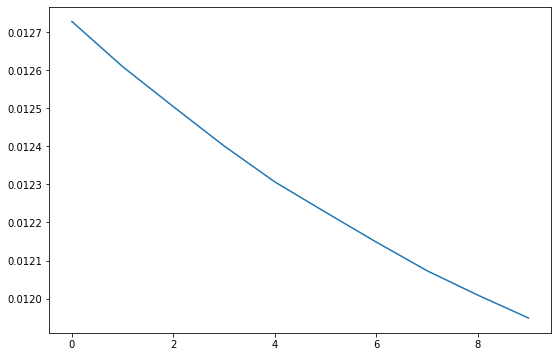

In [10]:
# 모델 훈련 수행
convAutoEncoderModel_training(model, optimizer, criterion, 10)

##### 8.4.1 Vanilla GAN

In [1]:
# 라이브러리 로드
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# 패션 아이템 데이터 불러오기
# transforms.Normalize((0.5,), (0.5,)) => 데이터를 -1 ~ 1 사이의 표준정규분로 만들어줌
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
trainset = FashionMNIST(root="./data/", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cup")

In [9]:
# 생성자 구축
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),            
            nn.Linear(1024, self.n_out),
            nn.Tanh())
    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [10]:
# 구별자 구축
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
            nn.Linear(self.n_in, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, self.n_out),
            nn.Sigmoid()) # 결과 값을 0~1 사이의 값(확률)으로 변환
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [15]:
# 모델, 손실함수, 옵티마이져
generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = optim.Adam(generator.parameters(), lr=2e-4) # 2e-4 = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4) # 2e-4 = 0.0002

g_lossStack = []
d_lossStack = []
imageStack = []
criterion = nn.BCELoss() # 손실함수

In [16]:
# 잠재 변수 및 라벨 정의하기
def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [17]:
# 구별자 학습 함수 정의
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)
    optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))    

    loss = d_loss + g_loss
    loss.backward()
    optimizer.step()
    return loss.item()

In [18]:
# 생성자의 학습 함수 정의
def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    # ※ loss의 역전파 수행시 Discriminator의 parameter 역전파 뿐만 아니라 
    # Generator parameter의 역전파까지 수행됨. 전체적으로 보았을 때 데이터의 흐름이 연결되어 있기 때문, 
    # 그래서 discriminator의 예측값으로 구한 loss로 Generator를 학습시킬 수 있음!
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [19]:
# 학습 수행
test_noise = noise(64)
l = len(trainloader)

for epoch in range(151):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optimizer, real_data, fake_data)
        fake_data = generator(z)
        g_loss += train_generator(g_optimizer, fake_data)

    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    imageStack.append(img)
    g_lossStack.append(g_loss/l)
    d_lossStack.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))
       
torch.save(discriminator.state_dict(), './models/fmnist_disc.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner.pth')  

Epoch 0: g_loss: 3.736 d_loss: 0.518
Epoch 10: g_loss: 2.260 d_loss: 0.668
Epoch 20: g_loss: 1.872 d_loss: 0.804
Epoch 30: g_loss: 1.800 d_loss: 0.799
Epoch 40: g_loss: 1.635 d_loss: 0.860
Epoch 50: g_loss: 1.762 d_loss: 0.848
Epoch 60: g_loss: 1.745 d_loss: 0.896
Epoch 70: g_loss: 1.578 d_loss: 0.923
Epoch 80: g_loss: 1.561 d_loss: 0.926
Epoch 90: g_loss: 1.415 d_loss: 0.976
Epoch 100: g_loss: 1.405 d_loss: 0.993
Epoch 110: g_loss: 1.388 d_loss: 0.992
Epoch 120: g_loss: 1.307 d_loss: 1.040
Epoch 130: g_loss: 1.337 d_loss: 1.074
Epoch 140: g_loss: 1.307 d_loss: 1.048
Epoch 150: g_loss: 1.399 d_loss: 1.080


In [21]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in imageStack]
imageio.mimsave('./images/fashion_items_gan.gif', imgs)

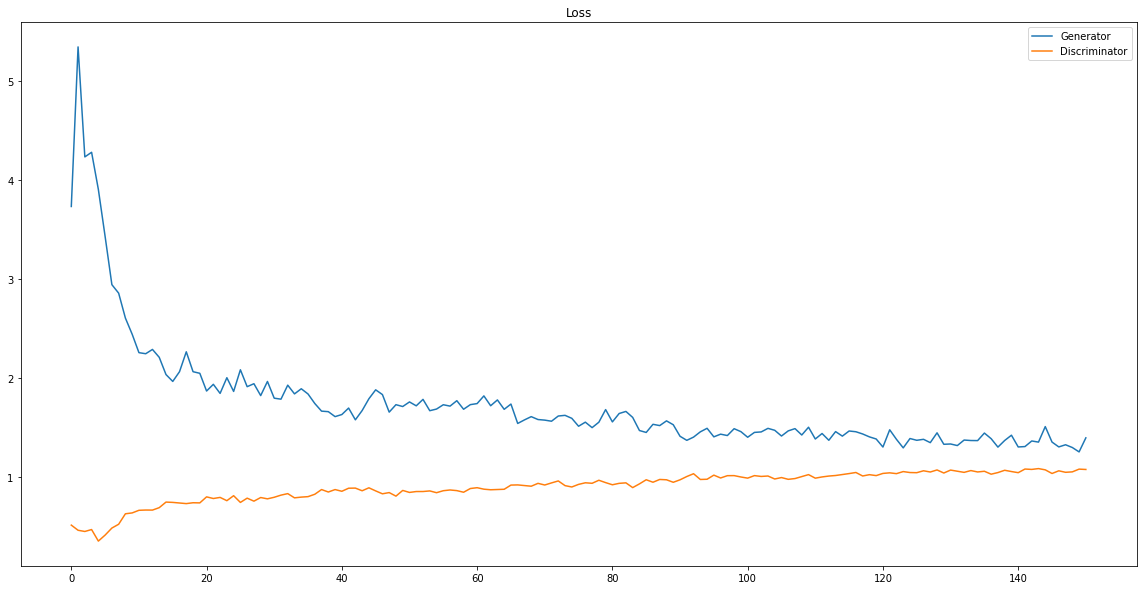

In [22]:
plt.figure(figsize=(20,10))
plt.plot(g_lossStack)
plt.plot(d_lossStack)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')